<a href="https://colab.research.google.com/github/dauparas/pytorch_examples/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic.ipynb and https://github.com/ilkhem/iVAE/blob/master/lib/models.py

In [0]:
import time
from numbers import Number
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
batch_size = 256
random_seed = 0
learning_rate = 5e-3
num_epochs = 10

In [4]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

0it [00:00, ?it/s]

9920512it [00:02, 3702004.92it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 58379.21it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 942551.97it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21767.73it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation='none', slope=.1, device='cuda'):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    def forward(self, x):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                h = self._act_f[c](self.fc[c](h))
        return h

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim, data_dim, n_layers=3, hidden_dim_enc=50, hidden_dim_dec=50, activation='lrelu', slope=.1, device='cuda'):
        super().__init__()

        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.hidden_dim_enc = hidden_dim_enc
        self.hidden_dim_dec = hidden_dim_dec
        self.n_layers = n_layers
        self.activation = activation
        self.slope = slope

        # decoder params
        self.f = MLP(latent_dim, data_dim, hidden_dim_enc, n_layers, activation=activation, slope=slope, device=device)
        # encoder params
        self.g = MLP(data_dim, latent_dim, hidden_dim_dec, n_layers, activation=activation, slope=slope, device=device)
        
    def encoder_params(self, x):
        g = self.g(x)
        return g

    def decoder_params(self, z):
        f = self.f(z)
        f = torch.sigmoid(f)
        return f

    def forward(self, x):
        encoder_params = self.encoder_params(x)
        decoder_params = self.decoder_params(encoder_params)
        return decoder_params, encoder_params

In [0]:
torch.manual_seed(random_seed)
model = AutoEncoder(latent_dim=32, data_dim=784, hidden_dim_enc=[256, 128, 64], hidden_dim_dec=[64, 128, 256], activation='lrelu', slope=.1, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
%%time
for epoch in range(num_epochs):
    for batch_idx, (features, _) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded, _ = model(features)
        cost = F.binary_cross_entropy(decoded.to(device), features)
        optimizer.zero_grad()

        cost.backward()
        optimizer.step()

        ### LOGGING
        if not batch_idx % 70:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

Epoch: 001/010 | Batch 000/235 | Cost: 0.6921
Epoch: 001/010 | Batch 070/235 | Cost: 0.2177
Epoch: 001/010 | Batch 140/235 | Cost: 0.1689
Epoch: 001/010 | Batch 210/235 | Cost: 0.1468
Epoch: 002/010 | Batch 000/235 | Cost: 0.1348
Epoch: 002/010 | Batch 070/235 | Cost: 0.1239
Epoch: 002/010 | Batch 140/235 | Cost: 0.1141
Epoch: 002/010 | Batch 210/235 | Cost: 0.1085
Epoch: 003/010 | Batch 000/235 | Cost: 0.1120
Epoch: 003/010 | Batch 070/235 | Cost: 0.1059
Epoch: 003/010 | Batch 140/235 | Cost: 0.1044
Epoch: 003/010 | Batch 210/235 | Cost: 0.1037
Epoch: 004/010 | Batch 000/235 | Cost: 0.1023
Epoch: 004/010 | Batch 070/235 | Cost: 0.0957
Epoch: 004/010 | Batch 140/235 | Cost: 0.0953
Epoch: 004/010 | Batch 210/235 | Cost: 0.0988
Epoch: 005/010 | Batch 000/235 | Cost: 0.0930
Epoch: 005/010 | Batch 070/235 | Cost: 0.0915
Epoch: 005/010 | Batch 140/235 | Cost: 0.0931
Epoch: 005/010 | Batch 210/235 | Cost: 0.0915
Epoch: 006/010 | Batch 000/235 | Cost: 0.0915
Epoch: 006/010 | Batch 070/235 | C

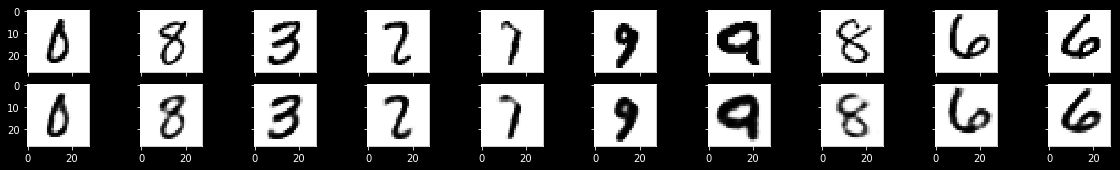

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('dark_background')


n_images = 10
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [0]:
model.eval()
latents_ = []
targets_ = []
cost_ = 0.0
with torch.no_grad():
  for batch_idx, (features, targets) in enumerate(test_loader):
    
# don't need labels, only the images (features)
    features = features.view(-1, 28*28).to(device)
    targets = targets.to(device)

    ### FORWARD AND BACK PROP
    _, latents = model(features)

    latents_.append(latents)
    targets_.append(targets)

latents_ = torch.cat(latents_, dim=0)
targets_ = torch.cat(targets_, dim=0)

latents_ = latents_.cpu().numpy()
targets_ = targets_.cpu().numpy()

In [11]:
latents_.shape

(10000, 32)

In [12]:
targets_.shape

(10000,)

In [0]:
subsample_indx = np.random.choice(range(latents_.shape[0]), size=5000, replace=False)

In [0]:
latents_sub = latents_[subsample_indx,:]
targets_sub = targets_[subsample_indx]

In [0]:
from sklearn.manifold import TSNE
emb = TSNE(n_components=2).fit_transform(latents_sub)

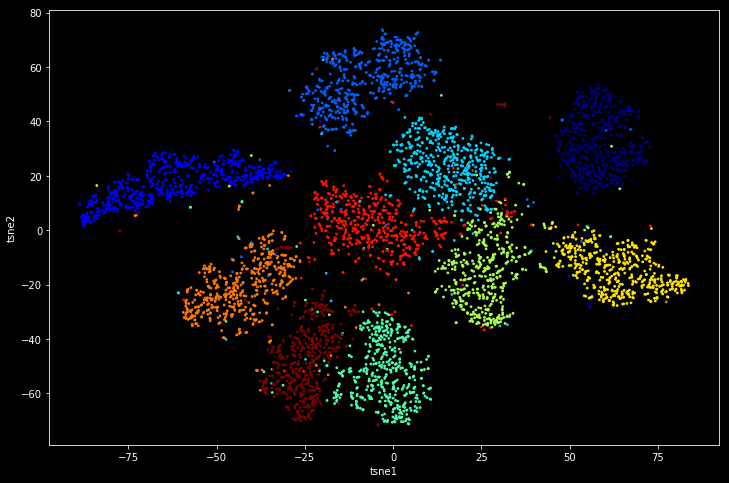

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(emb[:,0], emb[:,1], c=targets_sub, s=3.0, cmap='jet');
plt.xlabel('tsne1');
plt.ylabel('tsne2');